In [67]:
####################################
#ENVIRONMENT SETUP

In [68]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import xarray as xr

import sys; import os; import time; from datetime import timedelta
import pickle
import h5py

In [69]:
#MAIN DIRECTORIES
def GetDirectories():
    mainDirectory='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
    mainCodeDirectory=os.path.join(mainDirectory,"Code/CodeFiles/")
    scratchDirectory='/mnt/lustre/koa/scratch/air673/'
    codeDirectory=os.getcwd()
    return mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory

[mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory] = GetDirectories()

In [247]:
def GetPlottingDirectory(plotFileName, plotType):
    plottingDirectory = mainCodeDirectory=os.path.join(mainDirectory,"Code","PLOTTING")
    
    specificPlottingDirectory = os.path.join(plottingDirectory, plotType, 
                                             f"{ModelData.res}_{ModelData.t_res}_{ModelData.Nz_str}nz")
    os.makedirs(specificPlottingDirectory, exist_ok=True)

    plottingFileName=os.path.join(specificPlottingDirectory, plotFileName)

    return plottingFileName

def SaveFigure(fig,plotType, fileName):
    plotFileName = f"{fileName}_{ModelData.res}_{ModelData.t_res}_{ModelData.Np_str}.jpg"
    plottingFileName = GetPlottingDirectory(plotFileName, plotType)
    print(f"Saving figure to {plottingFileName}")
    fig.savefig(plottingFileName, dpi=300, bbox_inches='tight')

In [70]:
#IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"2_Variable_Calculation"))
from CLASSES_Variable_Calculation import ModelData_Class, SlurmJobArray_Class, DataManager_Class

In [71]:
#IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"3_Project_Algorithms","1_Domain_Profiles"))
from CLASSES_DomainProfiles import DomainProfiles_Class, DomainProfiles_DataLoading_Class

In [72]:
import sys
path=os.path.join(mainCodeDirectory,'Functions/')
sys.path.append(path)

import NumericalFunctions
from NumericalFunctions import * # import NumericalFunctions 
import PlottingFunctions
from PlottingFunctions import * # import PlottingFunctions

# # Get all functions in NumericalFunctions
# import inspect
# functions = [f[0] for f in inspect.getmembers(NumericalFunctions, inspect.isfunction)]
# functions

#####

#Import StatisticalFunctions 
import sys
dir2='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
path=dir2+'Functions/'
sys.path.append(path)

import StatisticalFunctions
from StatisticalFunctions import * # import NumericalFunctions 

In [253]:
dataName="Variables"

#data loading class
ModelData = ModelData_Class(mainDirectory, scratchDirectory, simulationNumber=1)
#data manager class
DataManager = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="Domain_Profiles", dataName=dataName,
                                dtype='float32',codeSection = "Project_Algorithms")

=== CM1 Data Summary ===
 Simulation #:   1
 Resolution:     1km
 Time step:      5min
 Vertical levels:34
 Parcels:        1e6
 Data file:      /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_1km_5min_34nz.nc
 Parcel file:    /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_pdata_1km_5min_1e6np.nc
 Time steps:     133

=== DataManager Summary ===
 inputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData
 outputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Project_Algorithms/Domain_Profiles
 inputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ModelData
 inputParcelDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-P

In [74]:
####################################
#PLOTTING FUNCTIONS

In [75]:
def LoadMeanLFC():
    # dir2 = dir + f'Project_Algorithms/Tracking_Algorithms/OUTPUT/'
    # in_file = dir2 + f"MeanLFC_{res}_{t_res}_{Np_str}.pkl"
    # with open(in_file, 'rb') as f:
    #     MeanLFC = pickle.load(f)
    MeanLFC=2 #*#*
    return MeanLFC
MeanLFC=LoadMeanLFC()
print(f"Mean LFC is: {MeanLFC}\n")


def LoadAllCloudBase():
    # dir2 = dir + f'Project_Algorithms/Tracking_Algorithms/OUTPUT/'
    # in_file = dir2 + f"all_cloudbase_{res}_{t_res}_{Np_str}.pkl"
    # with open(in_file, 'rb') as f:
    #     all_cloudbase = pickle.load(f)
    all_cloudbase=1 #*#*
    return(all_cloudbase)
min_all_cloudbase=np.nanmin(LoadAllCloudBase())
cloudbase=min_all_cloudbase
print(f"Minimum Cloudbase is: {cloudbase}\n")

Mean LFC is: 2

Minimum Cloudbase is: 1



In [76]:
#thresholds
w_thresh1,w_thresh2,qcqi_thresh = DomainProfiles_DataLoading_Class.GetCloudyUpdraftThresholds()

In [100]:
def LoadProfiles(datatype, masked, varNames):
    Dictionary = DomainProfiles_DataLoading_Class.LoadProfile(ModelData,DataManager, dataName, datatype,"timeaverage",masked)

    Dictionary_SE = {}
    for varName in varNames:
        one=Dictionary[f"{varName}_{datatype}_timeaverage"]
        two=Dictionary[f"{varName}_squares_{datatype}_timeaverage"]
        Dictionary_SE[f"{varName}_{datatype}_timeaverage_SE"] = ProfileStandardError(one,two)

    factor=1.96
    return Dictionary, Dictionary_SE, factor

In [249]:
def GetMultiplyFactor(varName):
    if varName in ["MSE"]:
        cpd=1005.7
        multiplyFactor = 1/cpd
        
    elif varName in ["qv","qcqi","HMC"]:
        multiplyFactor = 1000

    else:
        multiplyFactor = 1
    return multiplyFactor

def PlotProfile(profile, axis, label, color, xlabel, linestyle='solid'):
    axis.plot(profile[:, 0], profile[:, 1], label=label, color=color, linestyle=linestyle)
    axis.set_xlabel(xlabel)
    axis.set_ylabel("z (km)")
    axis.grid(True)
    
def PlotProfile_SE(profileMean,profile_SE,color,factor, axis):
    axis.fill_betweenx(profileMean[:, 1],
                       profileMean[:, 0] - factor*profile_SE[:, 0],
                       profileMean[:, 0] + factor*profile_SE[:, 0],
                       color=color, alpha=0.1)

def PlotProfiles(varNames, maskeds, datatypes, xlabels, title):
    """
    Plot vertical profiles for each variable in varNames.
    Each variable gets its own subplot, with lines for each datatype (e.g. 'general', 'cloudy').
    """
    n_varNames = len(varNames)
    n_cols = int(np.ceil(np.sqrt(n_varNames)))
    n_rows = int(np.ceil(n_varNames / n_cols))

    fig = plt.figure(figsize=(5 * n_cols, 4 * n_rows))
    gs = gridspec.GridSpec(n_rows, n_cols, figure=fig)

    # consistent color scheme for datatypes
    color_map = {'all': 'black', 'general': 'green', 'cloudy': 'blue'}

    for count, (varName, xlabel) in enumerate(zip(varNames, xlabels)):
        row, col = divmod(count, n_cols)
        ax = fig.add_subplot(gs[row, col])

        for (datatype, masked) in zip(datatypes, maskeds):
            Dictionary, Dictionary_SE, factor = LoadProfiles(datatype, masked, [varName])

            profile = Dictionary[f"{varName}_{datatype}_timeaverage"]
            profileMean = ProfileMean(profile)

            profile_SE = Dictionary_SE[f"{varName}_{datatype}_timeaverage_SE"]

            color = color_map.get(datatype, 'gray')
            label = f"{datatype}"
            if datatype == 'all':
                label = f"domain"

            multiplyFactor = GetMultiplyFactor(varName)
            profileMean[:,0]*=multiplyFactor
            profile_SE[:,0]*=multiplyFactor
            
            PlotProfile(profileMean, ax, label=label, color=color, xlabel=xlabel)
            PlotProfile_SE(profileMean,profile_SE, color, factor, ax)

            # plotting VMF_c on same plot as VMF_g
            if varName in ["VMF_c"]:
                varName2 = "VMF_g"
                profile = Dictionary[f"{varName2}_{datatype}_timeaverage"]
                profileMean = ProfileMean(profile)
    
                # profile_SE = Dictionary_SE[f"{varName}_{datatype}_timeaverage_SE"]
                PlotProfile(profileMean, ax, label=None, color=color, xlabel=xlabel, linestyle='dashed')
                # PlotProfile_SE(profileMean,profile_SE, factor, ax)
            

        ax.set_ylim(0,20)
        ax.legend()
        ax.grid(True)


    #FIXING TICKS
    axs = fig.get_axes()
    SnapLimitsToTicks(axs, dim='x')

    #matching w and vmf xrange
    ax_lst=[axs[3],axs[4]]; MatchAxisLimits(ax_lst,dim='x')

    #SCIENTIFIC NOTATION XLABEL
    apply_scientific_notation([axs[5]],decimals=2)
    apply_scientific_notation(axs[0:4+1],decimals=2,scientific=False)
    apply_scientific_notation(axs[6:],decimals=1,scientific=False)

    
    #ADDING AXLINES
    axline_lw=1.1
    for axis in axs:
        axis.axhline(cloudbase, color='purple', linestyle='dashed', lw=axline_lw)
        axis.axhline(MeanLFC, color='green', linestyle='dashed', lw=axline_lw)

    #ADDING AXVLINES
    for ax in axs[3:5+1]:
        ax.axvline(0,color='gray',linestyle='dashed',zorder=-10)


    #FIXING FIGURE LAYOUT
    # fig.tight_layout() #incompatible with SnapLimitsToTIcks
    fig.subplots_adjust(top=0.95, wspace=0.2, hspace=0.2)

    #setting figure title
    fig.suptitle(title)

    return fig

In [251]:
####################################
#RUNNING

Saving figure to /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/PLOTTING/Project_Algorithms/Domain_Profiles/Eulerian_Profiles_Variables/1km_5min_34nz/Eulerian_Profiles_Variables_1km_5min_1e6.jpg


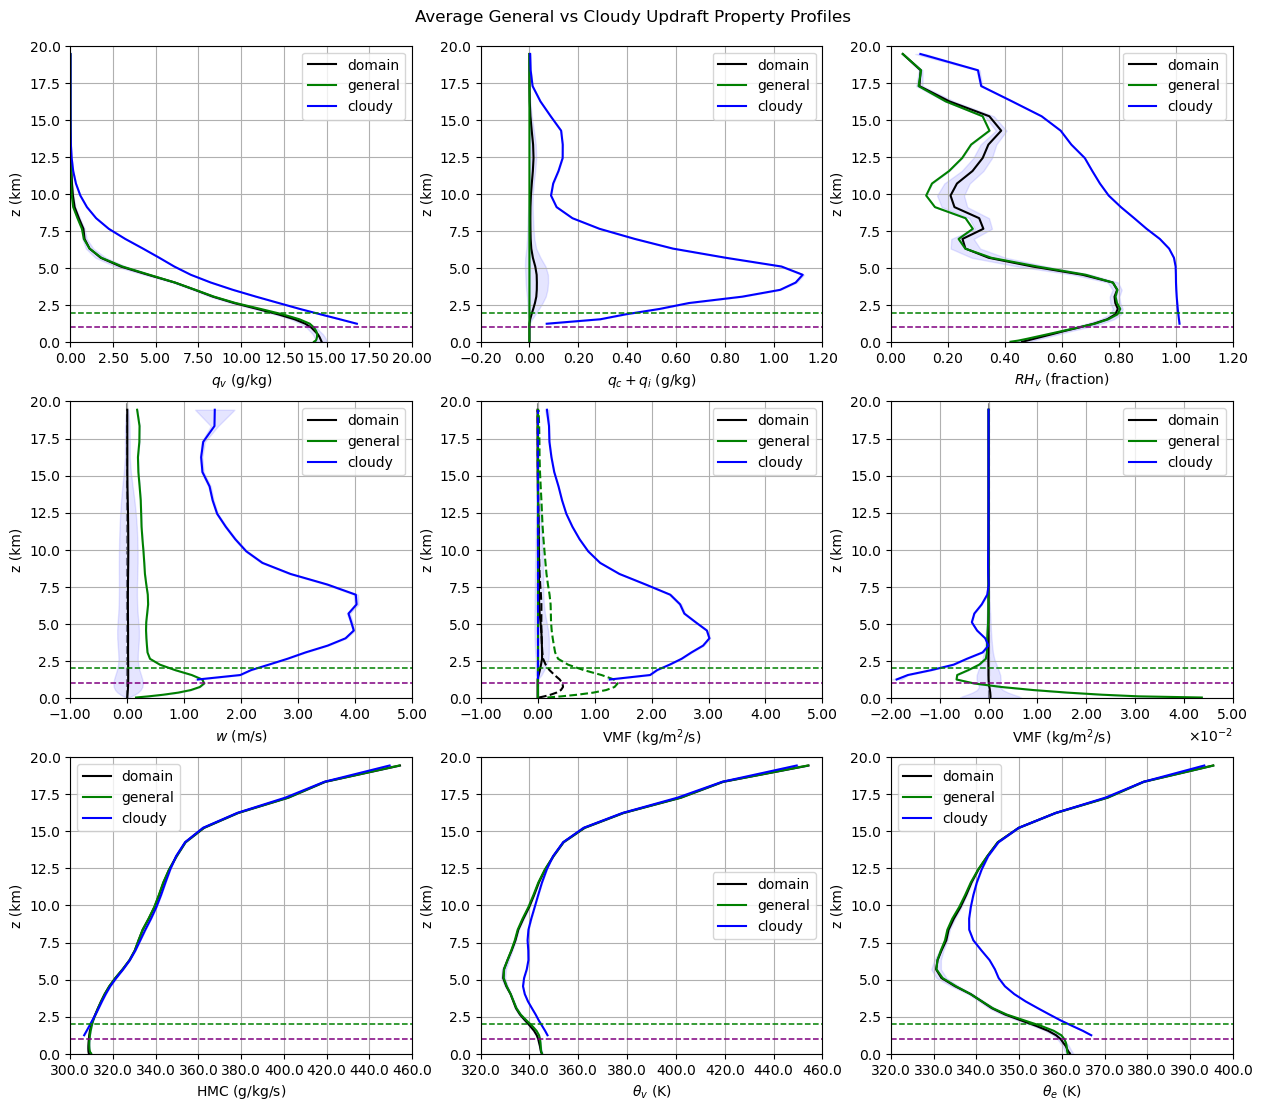

In [252]:
datatypes = ['all','general','cloudy']
maskeds = [False,True,True]
varNames=['qv','qcqi','RH_vapor',
      'winterp','VMF_c','HMC',
      'theta_v','theta_e','MSE'] 
xlabels = [
    r'$q_v$ $\mathrm{(g/kg)}$', 
    r'$q_c + q_i$ $\mathrm{(g/kg)}$', 
    r'$RH_v$ (fraction)',
    
    r'$w$ $\mathrm{(m/s)}$', 
    r'VMF $\mathrm{(kg/m^2/s)}$',
    r'VMF $\mathrm{(kg/m^2/s)}$',
    r'HMC $\mathrm{(g/kg/s)}$', 
    
    r'$\theta_v$ $\mathrm{(K)}$', 
    r'$\theta_e$ $\mathrm{(K)}$', 
    r'$\mathrm{MSE}/c_{pd}$ $\mathrm{(K)}$', 
]

title=f"Average General vs Cloudy Updraft Property Profiles"
fig = PlotProfiles(varNames, maskeds, datatypes, xlabels, title)

fileName=f"Eulerian_Profiles_Variables" 
SaveFigure(fig,plotType="Project_Algorithms/Domain_Profiles/Eulerian_Profiles_Variables",fileName=fileName)